# Introduction to Convolution Neural Networks (or CNN's)

Computer vision is the practise of writing algorithms which can discover patterns in visual data. Such as the camer of a self driving car recognizing what in front of the car !

In [1]:
!nvidia-smi

Mon Mar 22 00:59:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get the data

The images we're working with are from the Food101 dataset (101 different classes of food)

We have modified the data to only use 2 classes (pizza & steak) using the image data modification notebook (https://github.com/mrdbourke/tensorflow-deep-learning/tree/main/extras)

> *Note*:We start with a smaller dataset so we can experiment quickly and figure out what works (or what doesnt work)

In [2]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile('pizza_steak.zip')
zip_ref.extractall()
zip_ref.close()

--2021-03-22 00:59:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.240, 172.217.15.80, 172.217.7.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109579078 (105M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.50M  87.6MB/s    in 1.2s    

2021-03-22 00:59:57 (87.6 MB/s) - ‘pizza_steak.zip’ saved [109579078/109579078]



## Inspect the data (become one with the data)

A very crucial step at the beigning of any ML project is becoming one with the data.

And for a computer vision project.. this usaulaly means visualizing the data

In [3]:
!ls pizza_steak

test  train


In [4]:
!ls pizza_steak/train/

pizza  steak


In [5]:
!ls pizza_steak/train/steak

1000205.jpg  1647351.jpg  2238681.jpg  2824680.jpg  3375959.jpg  417368.jpg
100135.jpg   1650002.jpg  2238802.jpg  2825100.jpg  3381560.jpg  4176.jpg
101312.jpg   165639.jpg   2254705.jpg  2826987.jpg  3382936.jpg  42125.jpg
1021458.jpg  1658186.jpg  225990.jpg   2832499.jpg  3386119.jpg  421476.jpg
1032846.jpg  1658443.jpg  2260231.jpg  2832960.jpg  3388717.jpg  421561.jpg
10380.jpg    165964.jpg   2268692.jpg  285045.jpg   3389138.jpg  438871.jpg
1049459.jpg  167069.jpg   2271133.jpg  285147.jpg   3393547.jpg  43924.jpg
1053665.jpg  1675632.jpg  227576.jpg   2855315.jpg  3393688.jpg  440188.jpg
1068516.jpg  1678108.jpg  2283057.jpg  2856066.jpg  3396589.jpg  442757.jpg
1068975.jpg  168006.jpg   2286639.jpg  2859933.jpg  339891.jpg	 443210.jpg
1081258.jpg  1682496.jpg  2287136.jpg  286219.jpg   3417789.jpg  444064.jpg
1090122.jpg  1684438.jpg  2291292.jpg  2862562.jpg  3425047.jpg  444709.jpg
1093966.jpg  168775.jpg   229323.jpg   2865730.jpg  3434983.jpg  447557.jpg
1098844.jpg  1697

In [6]:
import os
# Walk through the pizza_steak dir and list number of files
for dirpath,dirnames, filenames in os.walk('pizza_steak'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 1 images in pizza_steak
There are 2 directories and 1 images in pizza_steak/test
There are 0 directories and 250 images in pizza_steak/test/pizza
There are 0 directories and 250 images in pizza_steak/test/steak
There are 2 directories and 1 images in pizza_steak/train
There are 0 directories and 750 images in pizza_steak/train/pizza
There are 0 directories and 750 images in pizza_steak/train/steak


In [7]:
# The extra file in our pizza_steak dir is '.DS_Store'
!ls -la pizza_steak

total 24
drwxr-xr-x 4 root root 4096 Mar 22 00:59 .
drwxr-xr-x 1 root root 4096 Mar 22 00:59 ..
-rw-r--r-- 1 root root 6148 Mar 22 00:59 .DS_Store
drwxr-xr-x 4 root root 4096 Mar 22 00:59 test
drwxr-xr-x 4 root root 4096 Mar 22 00:59 train


In [8]:
import matplotlib.pyplot as plt

In [9]:
# Another way to find out how imgs are in a folder
num_steak_images_train = len(os.listdir('./pizza_steak/train/steak'))

In [10]:
num_steak_images_train

750

To visualize our imgs first lets get class names programmatically

In [11]:
# Get the classnames programmatically
import pathlib
import numpy as np
data_dir = pathlib.Path('pizza_steak/train')
class_names = np.array(sorted(item.name for item in data_dir.glob('*'))) # Created a list of classes
class_names = class_names[1:]
print(class_names)
# or
class_names = os.listdir('pizza_steak/train')
print(class_names)
class_names = list(class_names)
print(class_names)
class_names.remove('.DS_Store')
print(class_names)

['pizza' 'steak']
['.DS_Store', 'pizza', 'steak']
['.DS_Store', 'pizza', 'steak']
['pizza', 'steak']


In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir:str,target_class:str):
  # Setup the target dir
  target_folder = target_dir+'/'+target_class
  print(target_folder)
  random_image = random.sample(os.listdir(target_folder),1)
  print(random_image)
  # Read the image and plot the image
  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off');
  print(f'Img Shape : {img.shape}')
  return img

pizza_steak/train/pizza
['32004.jpg']
Img Shape : (384, 512, 3)


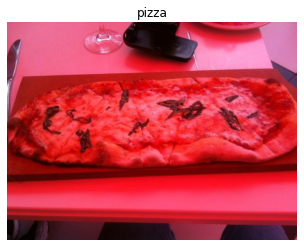

In [13]:
# View a random image from the training dataset
img = view_random_image(target_dir='pizza_steak/train',target_class='pizza')

In [14]:
import tensorflow as tf


In [15]:
tf.constant(img)

<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
array([[[213,  92, 127],
        [213,  92, 127],
        [213,  92, 127],
        ...,
        [206, 111, 153],
        [205, 110, 152],
        [205, 110, 152]],

       [[212,  91, 126],
        [213,  92, 127],
        [213,  92, 127],
        ...,
        [206, 113, 157],
        [206, 111, 153],
        [206, 111, 153]],

       [[211,  91, 126],
        [211,  91, 126],
        [212,  92, 127],
        ...,
        [208, 115, 159],
        [206, 114, 155],
        [205, 113, 154]],

       ...,

       [[ 28,  19,  24],
        [ 29,  20,  25],
        [ 28,  19,  22],
        ...,
        [143,  65,  81],
        [183,  91, 112],
        [171,  73,  96]],

       [[ 26,  17,  22],
        [ 28,  19,  24],
        [ 27,  18,  23],
        ...,
        [167,  84, 102],
        [174,  79, 101],
        [178,  74,  99]],

       [[ 24,  15,  20],
        [ 26,  17,  22],
        [ 26,  17,  22],
        ...,
        [165,  82,  9

In [16]:
img.shape # returns width height color channels

(384, 512, 3)

In [17]:
a = tf.constant(img) / np.array(img).max()

In [18]:
np.max(a)

1.0

In [19]:
np.min(a)

0.0

In [20]:
del a

In [21]:
img/np.max(img) # 255.0

array([[[0.83529412, 0.36078431, 0.49803922],
        [0.83529412, 0.36078431, 0.49803922],
        [0.83529412, 0.36078431, 0.49803922],
        ...,
        [0.80784314, 0.43529412, 0.6       ],
        [0.80392157, 0.43137255, 0.59607843],
        [0.80392157, 0.43137255, 0.59607843]],

       [[0.83137255, 0.35686275, 0.49411765],
        [0.83529412, 0.36078431, 0.49803922],
        [0.83529412, 0.36078431, 0.49803922],
        ...,
        [0.80784314, 0.44313725, 0.61568627],
        [0.80784314, 0.43529412, 0.6       ],
        [0.80784314, 0.43529412, 0.6       ]],

       [[0.82745098, 0.35686275, 0.49411765],
        [0.82745098, 0.35686275, 0.49411765],
        [0.83137255, 0.36078431, 0.49803922],
        ...,
        [0.81568627, 0.45098039, 0.62352941],
        [0.80784314, 0.44705882, 0.60784314],
        [0.80392157, 0.44313725, 0.60392157]],

       ...,

       [[0.10980392, 0.0745098 , 0.09411765],
        [0.11372549, 0.07843137, 0.09803922],
        [0.10980392, 0

## An End-to-End example

Lets build a CNN to find patterns in our image, more specifically we need a way to:

- Load our imgs
- Preproccess the imgs
- Build a CNN
- Compile 
- Fit

In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.random.set_seed(42)
# Preproccess data (get all of the pixel vals 0 & 1 also called as normalization)

train_datagen = ImageDataGenerator(rescale=1./255)
print(train_datagen)
print(train_datagen)
valid_datagen = ImageDataGenerator(rescale=1./255)
print(valid_datagen)

# Setup paths to our data dir's

train_dir = '/content/pizza_steak/train'
test_dir = '/content/pizza_steak/test'

# Import data from dir's and turn them to batches

train_data = train_datagen.flow_from_directory(train_dir,batch_size=32,target_size=(224,224),class_mode='binary',seed=42)
print(train_data)
valid_data = valid_datagen.flow_from_directory(test_dir,batch_size=32,target_size=(224,224),class_mode='binary',seed=42)
print(valid_data)

# Bui;d a CNN model (same as the tiny VGG on CNN explainer web site)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10,kernel_size=3,activation='relu',input_shape=(224,224,3)),

  tf.keras.layers.Conv2D(10,3,activation='relu'),

  tf.keras.layers.MaxPool2D(pool_size=2,padding='valid'),

  tf.keras.layers.Conv2D(10,3,activation='relu'),

  tf.keras.layers.Conv2D(10,3,activation='relu'),

  tf.keras.layers.MaxPool2D(2),

  tf.keras.layers.Flatten(),
  
  tf.keras.layers.Dense(1,activation='sigmoid')
])
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'],optimizer=tf.keras.optimizers.Adam())
history_1 = model_1.fit(train_data,epochs=5,steps_per_epoch=len(train_data),validation_data=(valid_data),validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 43s 211ms/step - loss: 0.6430 - accuracy: 0.6368 - val_loss: 0.3893 - val_accuracy: 0.8260
Epoch 2/5
47/47 [==============================] - 9s 196ms/step - loss: 0.4192 - accuracy: 0.7925 - val_loss: 0.3431 - val_accuracy: 0.8600
Epoch 3/5
47/47 [==============================] - 9s 198ms/step - loss: 0.3806 - accuracy: 0.8331 - val_loss: 0.3597 - val_accuracy: 0.8460
Epoch 4/5
47/47 [==============================] - 9s 198ms/step - loss: 0.3478 - accuracy: 0.8496 - val_loss: 0.3221 - val_accuracy: 0.8720
Epoch 5/5
47/47 [==============================] - 9s 196ms/step - loss: 0.3517 - accuracy: 0.8522 - val_loss: 0.2650 - val_accuracy: 0.9020


In [23]:
# GPU's takes less time :)

In [24]:
len(train_data)

SyntaxError: ignored

In [ ]:
1500/32

In [ ]:
model_1.summary()

## Using the same model as before

In [ ]:
tf.random.set_seed(42)
model_2 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224,224,3)),
  tf.keras.layers.Dense(4,activation='relu'),
  tf.keras.layers.Dense(4,activation='relu'),
  tf.keras.layers.Dense(1,activation='sigmoid')
])
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'],optimizer=tf.keras.optimizers.Adam())
history_2 = model_2.fit(train_data,epochs=5,validation_data=(valid_data),steps_per_epoch=len(train_data),validation_steps=len(valid_data))

In [ ]:
model_2.summary()

In [ ]:
  # tf.keras.layers.Flatten(input_shape=(224,224,3)),
  # tf.keras.layers.Dense(4,activation='relu'),
  # tf.keras.layers.Dense(4,activation='relu'),
  # tf.keras.layers.Dense(1,activation='sigmoid')
  ## old

In [ ]:
tf.random.set_seed(42)
model_3 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224,224,3)),
  tf.keras.layers.Dense(100,activation='relu'),
  tf.keras.layers.Dense(100,activation='relu'),
  tf.keras.layers.Dense(100,activation='relu'),
  tf.keras.layers.Dense(1,activation='sigmoid')
])
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'],optimizer=tf.keras.optimizers.Adam())
history_3 =  model_3.fit(train_data,validation_data=(valid_data),steps_per_epoch=len(train_data),validation_steps=len(valid_data),epochs=5)

In [ ]:
# Get summary of model_3
model_3.summary()

In [ ]:
1./255

## Binary classification : Lets break it down
1. Become one with the data (visualize,visualize,visualize)
2. Preproccess the data (prepared it for our model, the main step here is normalizing)
3. Created a model
4. Fit the model
5. Evluate the model
6. Adjust different params and improve the model (try to beat our baseline)
7. Repeat until sataisfied (experiment,experiment,experiment)

### 1.0 Become one with the data

In [ ]:
# Visualize data
plt.figure()
plt.subplot(1,2,1)
steak_img = view_random_image('pizza_steak/train/','steak')
plt.subplot(1,2,2)
steak_img = view_random_image('pizza_steak/train/','pizza')

### 2.0 Preproccessing the data (prepare the data for a model)

In [ ]:
# Define dir's
train_dir = 'pizza_steak/train/'
test_dir = 'pizza_steak/test/'

Our next step is to turn our data into **batches**

A batch is a small subset of data. Rather than  look at all -10000 images at one time, a model might only look at 32 at a time.

It does this for a couple of reasons:
1. 10000 imgs (or more) might not fit into the memory of your proccessor (GPU)
2. Trying to learn in 10000 imgs in one hit could result in the model not beign able to learn very well.

Why 32? 

Becuase 32 is good for your health... 

In [ ]:
1/255

In [ ]:
# Create train and test data generators and rescale the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255) # divide the data by 255 (1/255)
test_datagen = ImageDataGenerator(rescale=1/255) # divide the data by 255 (1/255)

In [ ]:
# Load in our image data from dirs and turn them into batches
train_data = train_datagen.flow_from_directory(directory=train_dir, # directory
                                               target_size=(224,224), # Target size of imgs (height and width)
                                               class_mode='binary', # type of data you're working with
                                               batch_size=32) # size of mini batches to load data into
test_data = test_datagen.flow_from_directory(directory=test_dir,target_size=(224,224),class_mode='binary',batch_size=32)

In [ ]:
# Get a sample of a train data batch
images,labels = train_data.next()

In [ ]:
# images

In [ ]:
# How many batches are there
len(train_data)

In [ ]:
len(images)

In [ ]:
len(labels)

In [ ]:
labels

In [ ]:
train_data

In [ ]:
1500/32

In [ ]:
len(test_data)

In [ ]:
len(labels)

In [ ]:
labels

In [ ]:
len(test_data[1])

In [ ]:
import pandas as pd

In [ ]:
pd.DataFrame(labels).value_counts()

In [ ]:
pd.DataFrame(next(test_data)[1]).value_counts()

In [ ]:
labels

In [ ]:
# So the images and labels we are getting are 1 of the images and labels set that means there are 47 more of them

## 3.0 Create a CNN model (start with a baseline)

A baseline is a realtively simple model or xisting result that you setup when beginning a ml experimenting, you try to beat the baseline

> Note : In deep learning there is almost an infinite amount of architectures you could create. So one of the best ways to get started is to start with something simple and see if it works on your data and then introduce complexity as required (eg look at which current model is performing the best in the field for your problem)

In [ ]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Activation
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [ ]:
# Create the model (this will be our baseline, a layer CNN)
model_4 = Sequential([
  Conv2D(filters=10, # how many like layers of like looking at the data (more fliter is better and it will make the model a big dog model) | 
         kernel_size=3, # size of the filter (more it find more features which are larger) (lower it find more features like per pixel) | 
         strides=1, # how many pixels it looks at ones (1 or 2) # 1
         padding='valid', # ("same" will have more data of the image than "valid") (so "same" is better to use but it depends)
         activation='relu', # activation type
         input_shape=(224,224,3)), # input shape of images (height,width, color channels)
  Conv2D(10,
         3,
         activation='relu'),

  Conv2D(10,
         3,
         activation='relu'),
        
  Flatten(),
  Dense(1,
        activation='sigmoid')
])
# model_4.compile(optimizer=Adam(),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
# model_4.fit(train_data,steps_per_epoch=len(train_data),validation_steps=(len(valid_data)),validation_data=(valid_data))

the above may not be correct

In [ ]:
# Create the model (this will be our baseline, a layer CNN)
model_4 = Sequential([
  Conv2D(filters=10, # filters is the number of sliding windows going across as input (higher = more complex model)
         kernel_size=(3,3), # size of the sliding window
         strides=(1,1), # the size of the step the sliding window takes across an input
         padding='valid', # if "same", output shape is as input shape, if "valid", output shape gets compresed
         activation='relu',
         input_shape=(224,224,3)),
  
  Conv2D(10,
         3,
         activation='relu'),

  Conv2D(10,
         3,
         activation='relu'),
        
  Flatten(),
  Dense(1,
        activation='sigmoid')
])

## 4.0 Fit the model

In [ ]:
# # Create the model (this will be our baseline, a layer CNN)
# model_5 = Sequential([
#   Conv2D(filters=10, # filters is the number of sliding windows going across as input (higher = more complex model)
#          kernel_size=(3,3), # size of the sliding window
#          strides=(1,1), # the size of the step the sliding window takes across an input
#          padding='same', # if "same", output shape is as input shape, if "valid", output shape gets compresed
#          activation='relu',
#          input_shape=(224,224,3)),
  
#   Conv2D(10,
#          3,
#          activation='relu',padding='same'),

#   Conv2D(10,
#          3,
#          activation='relu',padding='same'),
        
#   Flatten(),
#   Dense(1,
#         activation='sigmoid')
# ])
# model_5.compile(optimizer=Adam(),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
# model_5.fit(train_data,steps_per_epoch=len(train_data),validation_steps=(len(valid_data)),validation_data=(valid_data),epochs=5)
# "Same" is better but check "valid" also

In [ ]:
# model_5.summary()

In [ ]:
len(train_data),len(test_data)

In [ ]:
model_4.compile(optimizer=Adam(),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
# train_data is the combo of X and y data
# test_data is the combo of X and y data
history_4 = model_4.fit(train_data,steps_per_epoch=len(train_data),validation_steps=(len(valid_data)),validation_data=(valid_data),epochs=5)

In [ ]:
model_4.evaluate(valid_data)

In [ ]:
model_4.summary()

### 5.0 Evaluate our model

It looks like our model is learning something, lets evaluate it.

In [ ]:
# Lets plot the learing curve
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize=(10,7))

In [ ]:
# PLot the validation and training cuves separately
def plot_loss_curves(history):
  """"
  Returns seperature loss curves for training and validation metrics
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  
  val_accuracy = history.history['val_accuracy']
  accuracy = history.history['accuracy']

  epochs = range(len(history.history['loss'])) # num of epochs

  # PLot loss
  plt.plot(epochs,loss,label='train_loss')
  plt.plot(epochs,val_loss,label='val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label='train_accuracy')
  plt.plot(epochs,val_accuracy,label='val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()

> Note : When a model's valid loss starts to increase it likely that the model is overfitting the training data set. This mean its learning the pattern in the training dataset too well and thus the model's ability to generalize unseeb data will be hard

In [ ]:
# Check out the loss and accuracy of model_4
plot_loss_curves(history_4)

> the validation data and train data's accuracy and loss should be going like the same other wise the model should be overfitting or underfitting

### 6.0 Adjust the model params 

Fitting a ML model come in 3 steps:

0. Create a baseline
1. Beat the baseline by overfitting a larger model
2. Reduce overfitting

Ways to induce overfitting

* Increase the number of conv layers
* Increase the number of conv filters
* Add another dense layer to the output of our flattend layer

Reduce overfiting
* Add data augmentation
* Add regularzation layers (suck as MaxPool2D)
* Add more data...

> regularzation is also know as reducing overfitting

MaxPool2D : https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTIXCimzCJSpNb5tKXmZwkrMi2YPtJFbVP7u0EGCfzTx4cHWibbY7VXg2NLxV77FYNAIZ4&usqp=CAU

In [ ]:
# Create the model (this is going to be our new baseline)
model_5 = Sequential([
  Conv2D(10,3,activation='relu',input_shape=(224,224,3)),#,padding='same'),
  MaxPool2D(pool_size=2),
  Conv2D(10,3,activation='relu'),
  MaxPool2D(2), # Max Pool learns the most important features of the data
  Conv2D(10,3,activation='relu'),
  MaxPool2D(2),
  Flatten(),
  Dense(1,activation='sigmoid')
])

In [ ]:
model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
history_5 = model_5.fit(train_data,epochs=5,steps_per_epoch=len(train_data),validation_data=(valid_data),validation_steps=len(valid_data))

In [ ]:
model_5.summary()

In [ ]:
# max pull just gets the most feature per 2 pixels (4) and then adds the max one
# max pool cuts the image pixels in half

In [ ]:
 # Lower total params make the models faster to train I gueess not sure

In [ ]:
plot_loss_curves(history_5)

In [ ]:
model_4.summary()

##### Total parameters in `model_5` is the most important stuff like maybe the `model_4` got 477000 but there is alot of useless data so what `MaxPool2D` do is find the most important stuff

### Opening our bag of traicks and find data augmentation

In [ ]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.0,
                                             rotation_range=0.2, # how much do you want to rotate an image ? 
                                             shear_range=0.2, # how much do you want to shear an image ? (a strain produced by pressure in the structure of a substance, when its layers are laterally shifted in relation to each other.)
                                             zoom_range=0.2, # zoom in randomly in an image
                                             width_shift_range=0.2, # move the image around in the X axis
                                             height_shift_range=0.2, # move the image around in the y axis
                                             horizontal_flip=True) # flip a image ? 
# all of the params are also done randomly so the params will not be effect to all of the data

# Create imagedatagenerator without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.0)

# Create imagedatagenerator without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.0)
# os.mkdir('./load')
# load_dir = "/load/"
# load_datagen = ImageDataGenerator(rescale=1/255.0)

> ? What is data augmentation

Data augmentation is the proccess of altering our training data, leading it to have more diversity and it turn allowing our models to learn more generalizable patterns. Alterning might mean adjusting the rotation of an image, flipping it, etc...

Lets write some code to visualize data augmentation...

In [ ]:
# Import data and augment it from train dir
print('Augmented Train data')
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,target_size=(224,224),batch_size=32,class_mode='binary',shuffle=False) # use suffle=True
# Create non-augmented train data
print('Non-Augmented Train data')
train_data = train_datagen.flow_from_directory(train_dir,target_size=(224,224),batch_size=32,class_mode='binary',shuffle=False) # use suffle=True
# Create non-augmented test data
print('Non-Augmented Train data')
test_data = test_datagen.flow_from_directory(test_dir,target_size=(224,224),batch_size=32,class_mode='binary') # use suffle=True

> Note : Data augmentation is usually only performed on the training data. our images are left as they are in the dir but they are modified when its loaded to the notebook

Finally, lets visualize some augmented data!!

In [ ]:
# Get sample data batches
images,labels = train_data.next()
augmented_images,augmented_labels = train_data_augmented.next()

In [ ]:
random_number = random.randint(0,32) # our batch size are 32...
print(random_number)
plt.imshow(images[random_number])
plt.title(f'Original Image')
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title('Augmented Image')
plt.axis(False)
plt.show()

In [ ]:
model_5.summary()

Using augmented data to train a model

In [ ]:
!nvidia-smi

In [ ]:
model_6 = Sequential([
  Conv2D(10,3,activation='relu',input_shape=(224,224,3)),
  MaxPool2D(pool_size=2),
  Conv2D(10,3,activation='relu'),
  MaxPool2D(2),
  Conv2D(10,3,activation='relu'),
  MaxPool2D(2),
  Flatten(),
  Dense(1,activation='sigmoid')
])
model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=Adam(),metrics=['accuracy'])
history_6 = model_6.fit(train_data_augmented,validation_data=(test_data),steps_per_epoch=len(train_data_augmented),validation_steps=len(test_data),epochs=5)

In [ ]:
print(model_6.evaluate(test_data))
print(model_5.evaluate(test_data))

In [ ]:
plot_loss_curves(history_6)

In [ ]:
plot_loss_curves(history_5)

In [ ]:
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,shuffle=True,target_size=(224,224),class_mode='binary',batch_size=32)
train_data = train_datagen.flow_from_directory(train_dir,target_size=(224,224),class_mode='binary',batch_size=32,shuffle=True)

In [ ]:
model_6.summary()

LETS SUFFLE THE AUUGMENTED DATA Traing data and train as before

In [ ]:
model_7 = Sequential(
    [
     Conv2D(10,3,activation='relu',input_shape=(224,224,3)),
     MaxPool2D(),
     Conv2D(10,3,activation='relu'),
     MaxPool2D(),
     Conv2D(10,3,activation='relu'),
     MaxPool2D(),
     Flatten(),
     Dense(1,activation='relu')   
    ]
)
model_7.compile(loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'],optimizer=Adam())
history_7 = model_7.fit(train_data_augmented,validation_data=(test_data),steps_per_epoch=len(train_data_augmented),validation_steps=len(test_data),epochs=5)

In [ ]:
plot_loss_curves(history_5)

In [ ]:
plot_loss_curves(history_6)

In [ ]:
plot_loss_curves(history_7)

In [ ]:
print(model_7.evaluate(test_data))
print(model_6.evaluate(test_data))
print(model_5.evaluate(test_data))

### 7. Repeat until satisfied

Since we already bitten our baseline there are few things we could try to continue to imrpove our model:
* Increase the number of model layers (more 'Cov2D' and 'MaxPool2D')
* Increase tje number of filters in each C layer (eg from 10 to 32 or even 64)
* Train for longer
* Find ideal `lr`
* Get more data
* Use **trainfer learning** to leverage what another model has learned and use it for our use case.

> Recreate the model on the CNN explainer website (same as `model_1`) and check how it works in the shuffled augmented data

In [ ]:
model_8 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10,kernel_size=3,activation='relu',input_shape=(224,224,3)),
  tf.keras.layers.Conv2D(10,3,activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=2,padding='valid'),
  tf.keras.layers.Conv2D(10,3,activation='relu'),
  tf.keras.layers.Conv2D(10,3,activation='relu'),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1,activation='sigmoid')
])
model_8.compile(loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'],optimizer=tf.keras.optimizers.Adam())
history_8 = model_1.fit(train_data_augmented,epochs=5,steps_per_epoch=len(train_data),validation_data=(test_data),validation_steps=len(test_data))

### Making a prediction with our trained model on our own custom data

In [ ]:
# Classes we're working with

In [ ]:
class_names

In [ ]:
# View our own image
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
steak = mpimg.imread('03-steak.jpeg')
plt.imshow(steak)
plt.axis(False);

In [ ]:
tf.expand_dims(steak,axis=0)

In [ ]:
# tf.constant(tf.expand_dims(steak))

> Note when you train a NN and you want to make a prediction with it on your own custom data, it is important than your custom data. the shapes should be the same

In [ ]:
# Create a funtion to import and image and resize it to be able to predict with our model
def load_and_prep_img(filename,img_shape=224):
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode the read file into a tensor
  img = tf.image.decode_image(img)
  # Resize the img
  img = tf.image.resize(img,[img_shape,img_shape])
  # Normalize the data
  img = img / 255.0
  return img

In [ ]:
steak = load_and_prep_img('03-steak.jpeg')
steak

In [ ]:
steak = tf.expand_dims(steak,axis=0)

In [ ]:
model_7.predict(steak)

In [ ]:
# 0 = pizza 1 = steak

In [ ]:
# Looks like our custom image is beign put through our model.

In [ ]:
# Class Names

In [ ]:
class_names

In [ ]:
pred = model_7.predict(steak)

In [ ]:
pred_class = class_names[int(tf.round(pred))]

In [ ]:
pred_class

In [ ]:
def pred_and_plot(model,filename,class_names=class_names):
  """
  Imports an image located at file name and plots the image
  """
  # Import the target image and preproccess it
  img = load_and_prep_img(filename)

  # Make a pred
  pred = model.predict(tf.expand_dims(img,axis=0))

  # Get predicted class
  pred_class = class_names[int(tf.round(pred))]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f'Pred : {pred_class} {tf.squeeze(pred)}%')
  plt.axis(False);

In [ ]:
pred_and_plot(model_5,'03-steak.jpeg')

In [ ]:
pred_and_plot(model_6,'03-steak.jpeg')

In [ ]:
pred_and_plot(model_7,'03-steak.jpeg')

In [ ]:
pred_and_plot(model_8,'03-steak.jpeg')

# our model works !!

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg

In [ ]:
pred_and_plot(model_7,'03-pizza-dad.jpeg')

# Multi-Class Classification

We've just been through bunch of the following steps with a binary classification problem (pizza vs steak), now we're going to step things up a notch with 10 clases of food

1. Become one with the data
2. Preproccess the data
3. Create a model (base line)
4. Fit the model (overfit it to make sure it works)
5. Evaluate the model
6. Adjust different hyperparameters
7. Repeat until satisfied

:)

## 1. Import data and become one with the data

In [ ]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Activation
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

In [ ]:
!unzip 10_food_classes_all_data.zip

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
no = 0
for type_of_food in os.listdir('10_food_classes_all_data/train'):
  no = no + len(os.listdir(f'10_food_classes_all_data/train/{type_of_food}'))
  print(no)

In [ ]:
# Setup the train and test directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [ ]:
# Lets get the class names
class_names = os.listdir(train_dir)

In [ ]:
class_names

In [ ]:
# Visualize, visualize, visualize
import random
img = view_random_image(target_dir='10_food_classes_all_data/train',target_class=str(random.choice(class_names)))

### 2. Preproccess the data

In [ ]:
# train_datagen = ImageDataGenerator(rescale=1/255.0,height_shift_range=0.2,width_shift_range=0.2,horizontal_flip=True,zoom_range=0.2,shear_range=0.2)
train_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [ ]:
train_data = train_datagen.flow_from_directory(train_dir,target_size=(224,224),class_mode='categorical')
test_data = test_datagen.flow_from_directory(test_dir,target_size=(224,224),class_mode='categorical')

In [ ]:
len(train_data)

In [ ]:
len(test_data)

In [ ]:
len(next(test_data)[1][0])

### 3. Create a model

In [ ]:
# 6

In [ ]:
# 7/235 [..............................] - ETA: 5:45 - loss: 9.2773 - accuracy: 0.0810


In [ ]:
model_8 = Sequential(
    [
      Conv2D(10,3,activation='relu',input_shape=(224,224,3)),
      Conv2D(10,3,activation='relu'),
      MaxPool2D(2),
      Conv2D(10,3,activation='relu'),
      Conv2D(10,3,activation='relu'),
      MaxPool2D(2),
      Flatten(),
      Dense(10,activation='softmax') 
    ]
)
model_8.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=Adam(),metrics=['accuracy'])
history_8 = model_8.fit(train_data,validation_data=test_data,epochs=5)

## 5. Evaluate the model

In [ ]:
model_8.evaluate(test_data)

In [ ]:
plot_loss_curves(history_8)

Looks like our "simply the model" expierment didnt work the accuracy went down.
Leta check our data augmentation

## Trying to reduce overfitting with data augmentation

Idealy we wnat to:
* Reduce overfitting
* Improve validation accuracy

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [ ]:
train_data = train_datagen.flow_from_directory(train_dir,target_size=(224,224),class_mode='categorical')
test_data = test_datagen.flow_from_directory(test_dir,target_size=(224,224),class_mode='categorical')

In [ ]:
model_10 = Sequential(
    [
      Conv2D(10,3,activation='relu',input_shape=(224,224,3)),
      Conv2D(10,3,activation='relu'),
      MaxPool2D(2),
      Conv2D(10,3,activation='relu'),
      Conv2D(10,3,activation='relu'),
      MaxPool2D(2),
      Flatten(),
      Dense(10,activation='softmax') 
    ]
)
model_10.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=Adam(),metrics=['accuracy'])
history_10 = model_10.fit(train_data,validation_data=test_data,epochs=5)

In [ ]:
model_10.evaluate(test_data)

In [ ]:
model_8.evaluate(test_data)

In [ ]:
plot_loss_curves(history_10)

Woah ! that looks much better, the loss curves are much closer to each other than the baseline model. if we train for longer we might see more improvments

### 7. Repeat until satisfied

- Train for longer
- Add more layers
- Add more filters
- More Data
- Tweak the `lr`
- Add more neurons
- Change activation funtions
- restructure the model's architecture
- different ways of data augmentation
- try tansfer learning `tl`

### Making a prediction with our trained model

In [ ]:
# class_names[tf.argmax(pred)]

In [ ]:
model_10.save('model_10.h5')
import tensorflow as tf
tf.keras.models.load_model('model_10.h5')